In [1]:
%pip install geopandas rasterio matplotlib scikit-learn pandas pyimpute xgboost lightgbm geojson rasterstats

Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
import pyimpute
import geopandas as gpd
import shutil
import glob
import numpy as np
import pandas as pd
import pickle

# Species Distribution Data Loading

Selected species is Alber Albifrons. If you want to process all species, see `./model_train.py`

In [15]:
species_list = ['Anser_albifrons', 'Haliaeetus_leucocephalus', 'Numenius_americanus', 'Numenius_phaeopus', 'Setophaga_striata']
species = species_list[0]
filetype = '.asc'

### Load Presence-Absence Data

In [3]:
for f in sorted(glob.glob('data/geojson/*')):
    shutil.copy(f,'inputs/')

pa_raw = gpd.GeoDataFrame.from_file('inputs/' + species + '.geojson')

In [8]:
#sample_size = 20000

#pa = pa_raw.sample(n=sample_size, random_state=1)
pa = pa_raw
pa.sample(5)

,CLASS,geometry
89862,0.0,POINT (-126.87500 67.62500)
115279,1.0,POINT (-97.61760 35.29067)
47342,1.0,POINT (-123.80352 49.49095)
25610,1.0,POINT (-156.84076 71.26423)
76939,0.0,POINT (-53.37500 -3.62500)


#### Display metrics for presence-absence data

In [9]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

print("\nnumber of presences: ", pa[pa.CLASS == 1].count())
print("number of absences: ", pa[pa.CLASS == 0].count())

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: EPSG:4326
162534 observations with 2 columns

number of presences:  CLASS       81267
geometry    81267
dtype: int64
number of absences:  CLASS       81267
geometry    81267
dtype: int64


<Axes: >

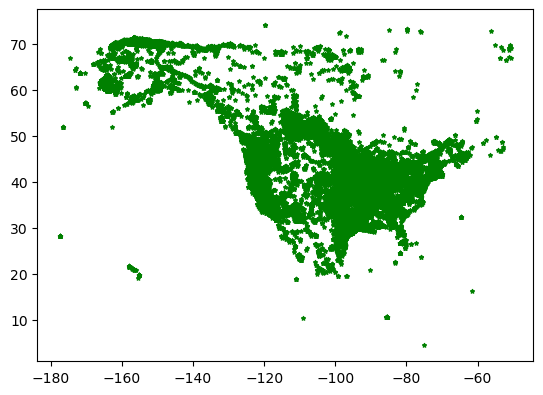

In [10]:
pa[pa.CLASS == 1].plot(marker='*', color='green', markersize=8)

<Axes: >

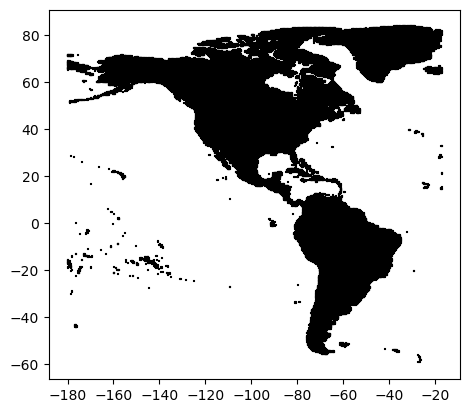

In [11]:
pa[pa.CLASS == 0].plot(marker='+', color='black', markersize=4)

# Climate Data Loading and Preprocessing

#### Load Climate Data

In [16]:
# grab climate features
raster_features = sorted(glob.glob(
    'data/MIROC6/historical/*' + filetype))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')


There are 2 raster features.


#### Load training vectors

In [ ]:
# Load training vectors
train_xs, train_y = pyimpute.load_training_vector(pa, raster_features, response_field='CLASS')

# Remove NaN rows (why do they exist?)
df = pd.DataFrame(train_xs)
row_index = df.index[df.isna().any(axis=1)].tolist()
print("NaN Rows:", row_index)

train_xs = np.delete(train_xs, row_index, axis=0)
train_y = np.delete(train_y, row_index, axis=0)

train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

#### Fit Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

# Create extra trees models
model = RandomForestClassifier()

# cross validation for accuracy scores (displayed as a percentage)
k = 5 # k-fold
kf = model_selection.KFold(n_splits=k)
accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
print("random forest %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
        % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))

# spatial prediction
model.fit(train_xs, train_y)

### Save model to PKL

In [ ]:
os.makedirs('outputs/models/', exist_ok=True)
filename = species + '_rf_classifier_model.pkl'
pickle.dump(model, open('outputs/models/' + filename, 'wb'))

# Predictive Modelling

Defaulted to ssp245 & 2050

If you want to run all predictions for all years & SSPs, see `./model_prediciton.py`

In [19]:
ssp = "ssp126"
year = 2050

#### Load targets

In [23]:
raster_features = sorted(glob.glob('data/MIROC6/' + ssp + '/' + str(year) + '/*' + filetype))
target_xs, raster_info = pyimpute.load_targets(raster_features)

# check number of features 
print('\nThere are', len(raster_features), 'raster features.')


There are 2 raster features.


#### Load model pickle file

In [ ]:
pickle_filename = "outputs/models/" + species + '_rf_classifier_model.pkl'
model = pickle.load(open(pickle_filename, 'rb'))

#### Make predictions!

In [ ]:
os.makedirs('outputs/tiff-images/' + species + '/' + ssp + '/' + str(year), exist_ok=True)
pyimpute.impute(target_xs, model, raster_info, outdir='outputs/tiff-images/' + species + '/' + ssp + '/' + str(year),
        class_prob=True, certainty=False)